<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/SAHI_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IceVision + SAHI: addressing low performance in small object detection

This notebook showcases the newly added IceVision + [SAHI](https://github.com/obss/sahi) integration.

You can find more detailed info about this work in [this blog post](https://francescopochetti.com/icevision-sahi-democratise-small-object-detection/).

## Installing Icevision and dependencies + SAHI

Install from pypi...

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

Install SAHI

In [ ]:
!pip install sahi -q

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

### Imports

In [ ]:
from icevision.all import *

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

### Loading the Fridge dataset

In [ ]:
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")

train_records, valid_records = parser.parse()

  0%|          | 0/20380998 [00:00<?, ?B/s]

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/128 [00:00<?, ?it/s]

### Defining augmentations and datasets

In [ ]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=(image_size, image_size), presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad((image_size, image_size)), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Choosing model

In [ ]:
# Just change the value of selection to try another model

selection = 0

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x
  #model_type = models.mmdet.faster_rcnn
  #backbone = model_type.backbones.resnet50_fpn_1x
  #model_type = models.mmdet.retinanet
  #backbone = model_type.backbones.resnet50_fpn_1x
  #model_type = models.mmdet.ssd
  #backbone = model_type.backbones.ssd512

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.faster_rcnn
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite1
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.medium
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

print(model_type, backbone, extra_args)

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

### Getting dataloaders, defining metrics and instantiate fastai learner

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=8, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=8, shuffle=False)

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Finding best learning rate

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.0004786300996784121)

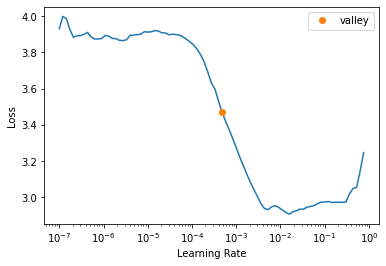

In [ ]:
learn.lr_find()

### Training the model

In [ ]:
learn.fine_tune(20, 3e-4, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,3.809848,3.245110,0.219802,00:22


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


epoch,train_loss,valid_loss,COCOMetric,time
0,2.858475,2.487748,0.435076,00:24
1,2.506602,1.631549,0.439791,00:19
2,2.196014,1.348319,0.443677,00:19
3,1.966267,1.245886,0.692616,00:19
4,1.783822,1.063900,0.778038,00:19
5,1.637959,0.931765,0.855932,00:19
6,1.499139,0.803554,0.919840,00:19
7,1.391289,0.777090,0.922477,00:19
8,1.303855,0.758904,0.918359,00:19
9,1.213133,0.675470,0.942594,00:19


### Downloading sample image

In [ ]:
!wget --no-check-certificate -O small_fridge.jpg 'https://docs.google.com/uc?export=download&id=16cq_RmKLuXLGXXiDwdyWcE-0HpyYU1kS'

--2021-11-30 18:12:37--  https://docs.google.com/uc?export=download&id=16cq_RmKLuXLGXXiDwdyWcE-0HpyYU1kS
Resolving docs.google.com (docs.google.com)... 172.217.214.101, 172.217.214.113, 172.217.214.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tt3td2mcu62ih3vqc4ummb85jq526859/1638295950000/14481291337477770344/*/16cq_RmKLuXLGXXiDwdyWcE-0HpyYU1kS?e=download [following]
--2021-11-30 18:12:37--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tt3td2mcu62ih3vqc4ummb85jq526859/1638295950000/14481291337477770344/*/16cq_RmKLuXLGXXiDwdyWcE-0HpyYU1kS?e=download
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 142.250.159.132, 2607:f8b0:4001:c58::84
Connecting to doc-0k-c0-docs.googleusercontent.com (doc-0k

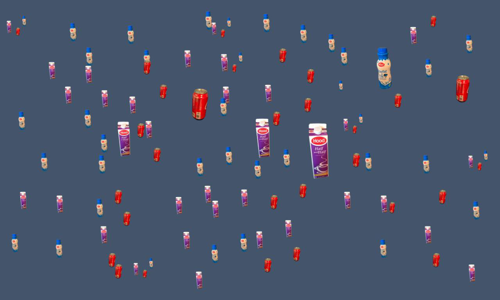

In [ ]:
PIL.Image.open("small_fridge.jpg").resize((500, 300))

### Running inference **without** SAHI

No bbox detected!


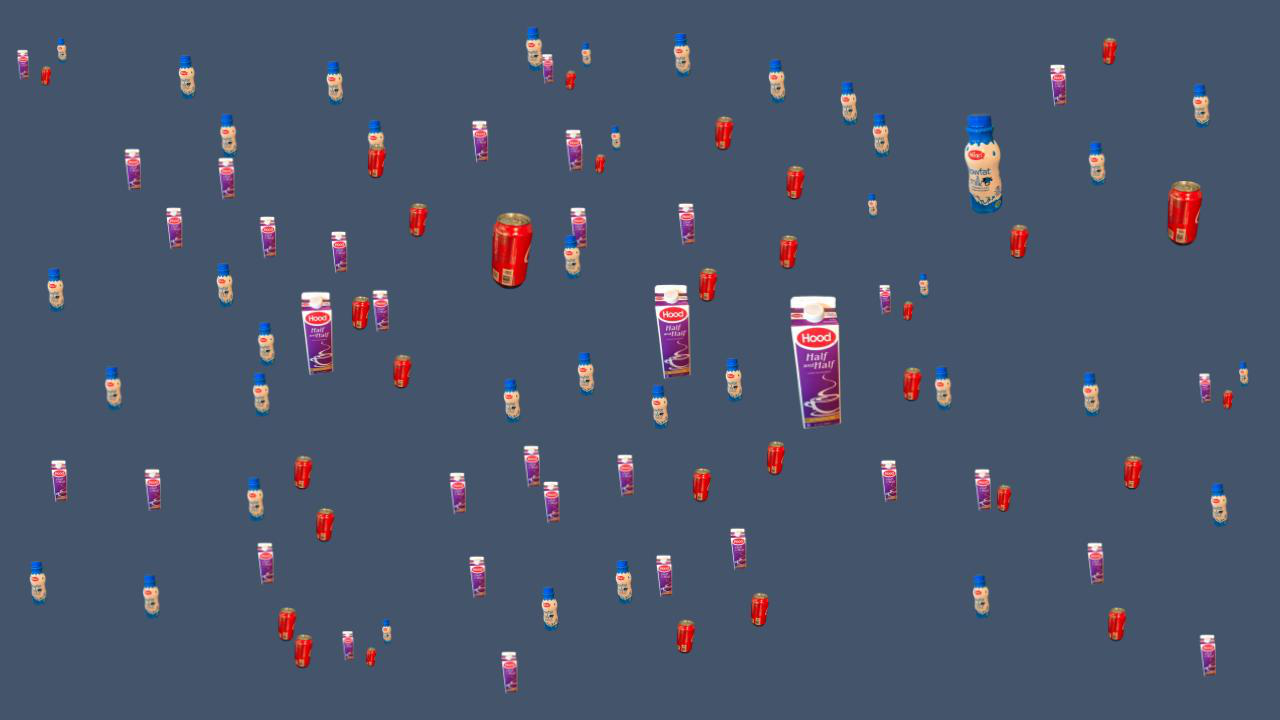

In [ ]:
img = PIL.Image.open("small_fridge.jpg")

pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=parser.class_map, detection_threshold=0.4)
pred_dict['img']

### Running inference **with** SAHI

Check out how almost all objects (too small for a one-shot prediction) are detected using the sliding window approach SAHI offers.

In [ ]:
from icevision.models.inference_sahi import IceSahiModel

In [ ]:
sahimodel = IceSahiModel(model_type=model_type, model=model, class_map=parser.class_map, tfms=valid_tfms, confidence_threshold=0.4)

In [ ]:
pred = sahimodel.get_sliced_prediction(
                "small_fridge.jpg",
                keep_sahi_format=False,
                return_img=True,
                slice_height = 128,
                slice_width = 128,
                overlap_height_ratio = 0.2,
                overlap_width_ratio = 0.2,
            )

Number of slices: 91


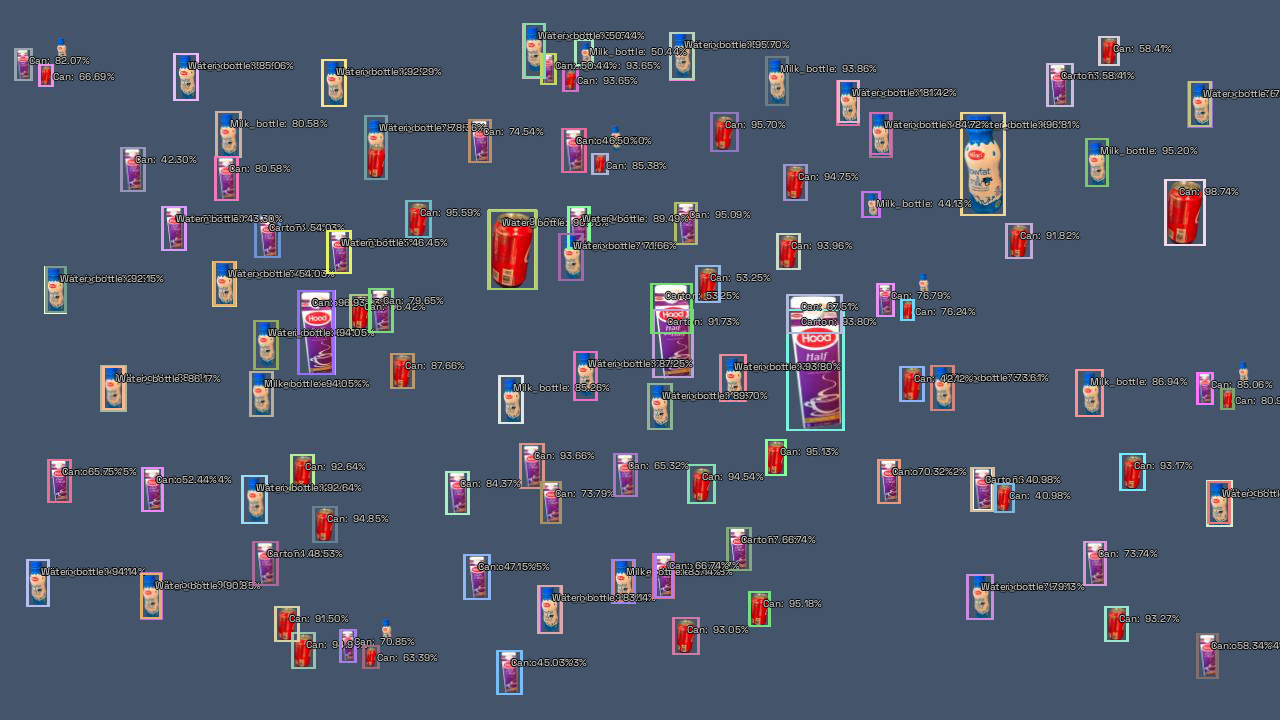

In [ ]:
pred["img"]